In [1]:
import random
import math
import numpy as np
from sklearn.datasets import make_moons
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as nnf

from util import load_Cifar10

cuda = True
DEVICE = torch.device("cuda" if cuda and torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [2]:
# define the autoencoder model
# class Autoencoder(nn.Module):
#     def __init__(self, input_size, hidden_size, bottleneck_size, layers):
#         super(Autoencoder, self).__init__()

#         assert(layers >= 2) # the network must have at least 2 layers
#         layers = layers - 2
#         # construct the encoder's interior layers as linear + relu
#         self.encoder = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU()
#             )
#         for i in range(1, layers):
#             self.encoder.add_module(str(2*i), nn.Linear(hidden_size, hidden_size))
#             self.encoder.add_module(str(2*i+1), nn.ReLU())
#         # the output layer is just linear
#         self.encoder.add_module(str(2*layers), nn.Linear(hidden_size, bottleneck_size))

#         # likewise for the decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(bottleneck_size, hidden_size),
#             nn.ReLU()
#             )
#         for i in range(1, layers):
#             self.decoder.add_module(str(2*i), nn.Linear(hidden_size, hidden_size))
#             self.decoder.add_module(str(2*i+1), nn.ReLU())
#         self.decoder.add_module(str(2*layers), nn.Linear(hidden_size, input_size))

#     def encode(self, x):
#         '''map data to code space'''
#         x = self.encoder(x)
#         return x
    
#     def decode(self, x):
#         '''map data from code space back to data space'''
#         x = self.decoder(x)
#         return x

#     def forward(self, x):
#         '''compress and uncompress data (forward function required by pytorch nn.Module)'''
#         x = self.encode(x)
#         x = self.decode(x)
#         return x

# def train_autoencoder(model, X_train, num_epochs=100, batch_size=32, lr=0.001, caption="autoencoder"):
#     # define the loss function and optimizer according to task description
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     criterion = nn.MSELoss()
#     # train the model
#     indices = list(range(len(X_train)))
#     for epoch in range(num_epochs):
#         for i in range(0, len(X_train), batch_size):
#             # get a random batch of data
#             random.shuffle(indices)
#             batch = torch.tensor(X_train[indices[i:i+batch_size]], dtype=torch.float32).to(DEVICE)
#             # forward pass
#             output = model.forward(batch)
        #     loss = criterion(output, batch)

        #     # backpropagation
        #     optimizer.zero_grad()
        #     loss.backward()
        #     optimizer.step()
        # # print the loss every 10 epochs
        # if (epoch+1) % 10 == 0:
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

In [3]:
# Load the digits dataset
#digits = load_digits()
# Split the dataset into train and test sets
#X_train_digits, X_test_digits, y_train_digits, y_test_digits = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)
# Scale the data
#scaler = StandardScaler()
#X_train_digits = scaler.fit_transform(X_train_digits)
#X_test_digits = scaler.transform(X_test_digits)

In [4]:
# def plot_digits_reconstructions(model, X_test, title=""):
#     # reconstruct the test set
#     with torch.no_grad():
#         decoded = model.forward(torch.tensor(X_test, dtype=torch.float32)).to("cpu")
#     # plot the original and reconstructed test set
#     fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(10, 2))
#     fig.suptitle("Originals (top), differences (center), and reconstructions (bottom)" + title)
#     for i in range(10):
#         # normalize decoded by the inter-quartile range (IQR) of X_test
#         # to make the difference more meaningful
#         qt1, qt3 = np.quantile(X_test[i], [0.25, 0.75])
#         qd1, qd3 = np.quantile(decoded[i], [0.25, 0.75])
#         iqr_ratio = (qt3 - qt1) / (qd3 - qd1)
#         decoded[i] = decoded[i] * iqr_ratio
#         # compute the difference between the original and reconstructed image
#         diff = X_test[i] - decoded[i].numpy()
#         # plot the original, difference, and reconstructed image
#         axes[0][i].imshow(X_test[i].reshape(8, 8), cmap='gray')
#         axes[1][i].imshow(diff.reshape(8, 8), cmap='gray')
#         axes[2][i].imshow(decoded[i].reshape(8, 8), cmap='gray')
#         # remove axis ticks for images
#         for k in range(3):
#             axes[k][i].set_xticks([])
#             axes[k][i].set_yticks([])

In [5]:
# train an autoencoder with bottleneck size 2 (note: data dimension is 64=8x8)
#model_digits_2 = Autoencoder(input_size=X_train_digits.shape[1], hidden_size=64, bottleneck_size=2, layers=5).to(DEVICE)
#train_autoencoder(model_digits_2, X_train_digits, num_epochs=1000, batch_size=256, lr=0.001)
#model_digits_2 = model_digits_2.to("cpu")
#plot_digits_reconstructions(model_digits_2, X_test_digits, ", bottleneck size 2")

In [6]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, bottleneck_size, layers):
        super(Encoder, self).__init__()

        assert(layers >= 2) # the network must have at least 2 layers
        layers = layers - 2
        # construct the encoder's interior layers as linear + relu
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
            )
        for i in range(1, layers):
            self.encoder.add_module(str(2*i), nn.Linear(hidden_size, hidden_size))
            self.encoder.add_module(str(2*i+1), nn.ReLU())
        # the output layer is just linear
        self.encoder.add_module(str(2*layers), nn.Linear(hidden_size, bottleneck_size))

    def forward(self, x):
        '''compress data to code space'''
        x = self.encoder(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, bottleneck_size, hidden_size, output_size, layers):
        super(Decoder, self).__init__()

        assert(layers >= 2) # the network must have at least 2 layers
        layers = layers - 2
        # construct the decoder's interior layers as linear + relu
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, hidden_size),
            nn.ReLU()
            )
        for i in range(1, layers):
            self.decoder.add_module(str(2*i), nn.Linear(hidden_size, hidden_size))
            self.decoder.add_module(str(2*i+1), nn.ReLU())
        self.decoder.add_module(str(2*layers), nn.Linear(hidden_size, output_size))

    def forward(self, x):
        '''compress data to code space'''
        x = self.decoder(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder
        self.decoder = Decoder
        self.loss = []

    def encode(self, x):
        '''map data to code space'''
        x = self.encoder(x)
        return x
    
    def decode(self, x):
        '''map data from code space back to data space'''
        x = self.decoder(x)
        return x

    def forward(self, x):
        '''compress and uncompress data (forward function required by pytorch nn.Module)'''
        x = self.encode(x)
        x = self.decode(x)
        return x

In [ ]:
x_dim = 32
channels = 3

scale_factor = 2
x_inp_dim  = int(x_dim / scale_factor)


hidden_dim = 512

lr = 1e-3
epochs = 100
batch_size = 512

train_dataset, test_dataset, train_loader, test_loader, classes = load_Cifar10(batch_size, [1])
num_train_data = len(train_dataset)

In [8]:
encoder = Encoder(bottleneck_size=256 ,input_size=x_inp_dim**2*channels, hidden_size=hidden_dim, layers=5)
decoder = Decoder(bottleneck_size=256  , hidden_size = hidden_dim, output_size = x_dim**2*channels, layers=5)

model = Autoencoder(Encoder=encoder, Decoder=decoder).to(DEVICE)

from torchsummary import summary
summary(encoder, input_size=(x_inp_dim**2*channels,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         393,728
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 512]         262,656
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 512]         262,656
              ReLU-6                  [-1, 512]               0
            Linear-7                  [-1, 256]         131,328
Total params: 1,050,368
Trainable params: 1,050,368
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 4.01
Estimated Total Size (MB): 4.04
----------------------------------------------------------------


In [9]:
from torchvision import models

class PerceptualLoss(nn.Module):
    def init(self):
        super().init()
        vgg = models.vgg16(pretrained=True).features[:16]  # Use first layers
        for param in vgg.parameters():
            param.requires_grad = False
        self.vgg = vgg

    def forward(self, pred, target):
        pred_features = self.vgg(pred)
        target_features = self.vgg(target)
        return F.mse_loss(pred_features, target_features) 

In [10]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
# train the model
for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x_inp = nnf.interpolate(x, size=(x_inp_dim, x_inp_dim), mode='bicubic', align_corners=False)
        x_inp = x_inp.view(-1, x_inp_dim**2*channels)
        x_inp = x_inp.to(DEVICE)

        x = x.view(-1, x_dim**2*channels)
        x = x.to(DEVICE)
        optimizer.zero_grad()

        x_hat = model.forward(x_inp)

        loss = criterion(x_hat, x)
        overall_loss += loss.item() / num_train_data
        # backpropagation
        loss.backward()
        optimizer.step()
    # print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    model.loss.append(overall_loss)

Epoch [10/100], Loss: 0.1168
Epoch [20/100], Loss: 0.0610
Epoch [30/100], Loss: 0.0548
Epoch [40/100], Loss: 0.0545
Epoch [50/100], Loss: 0.0533
Epoch [60/100], Loss: 0.0508
Epoch [70/100], Loss: 0.0476
Epoch [80/100], Loss: 0.0457
Epoch [90/100], Loss: 0.0457
Epoch [100/100], Loss: 0.0448


[]

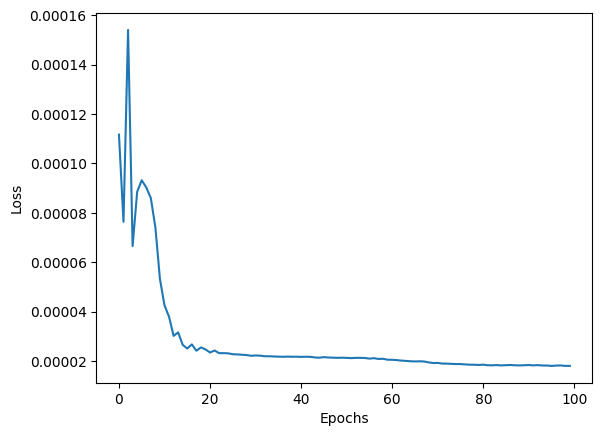

In [11]:
plt.plot(model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [12]:
from tqdm import tqdm
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x_inp = nnf.interpolate(x, size=(x_inp_dim, x_inp_dim), mode='bicubic', align_corners=False)
        print(x_inp.shape)
        x_inp = x_inp.view(-1, x_inp_dim**2*channels)
        x_inp = x_inp.to(DEVICE)
        x = x.view(-1, x_dim**2*channels)
        x = x.to(DEVICE)

        x_hat = model(x_inp)
        break

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1000, 3, 16, 16])


  0%|          | 0/1 [00:03<?, ?it/s]


In [13]:
def show_image(x, x_inp, x_hat, n):
    x = x.view(-1, channels, x_dim, x_dim)
    x_inp = x_inp.view(-1, channels, x_inp_dim, x_inp_dim)
    x_hat = x_hat.view(-1, channels, x_dim, x_dim)


    fig, axs = plt.subplots(3, n, figsize=(20, 6))
    for i in range(n):
        axs[0, i].imshow(x[i].permute(1, 2, 0).cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(x_inp[i].permute(1, 2, 0).cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(x_hat[i].permute(1, 2, 0).cpu().numpy())
        axs[2, i].axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.011979165..1.0094516].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0991843..1.0283701].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00048636692..0.894581].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.017172182..0.996649].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05640319..1.0111022].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.043424487..1.0417739].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.

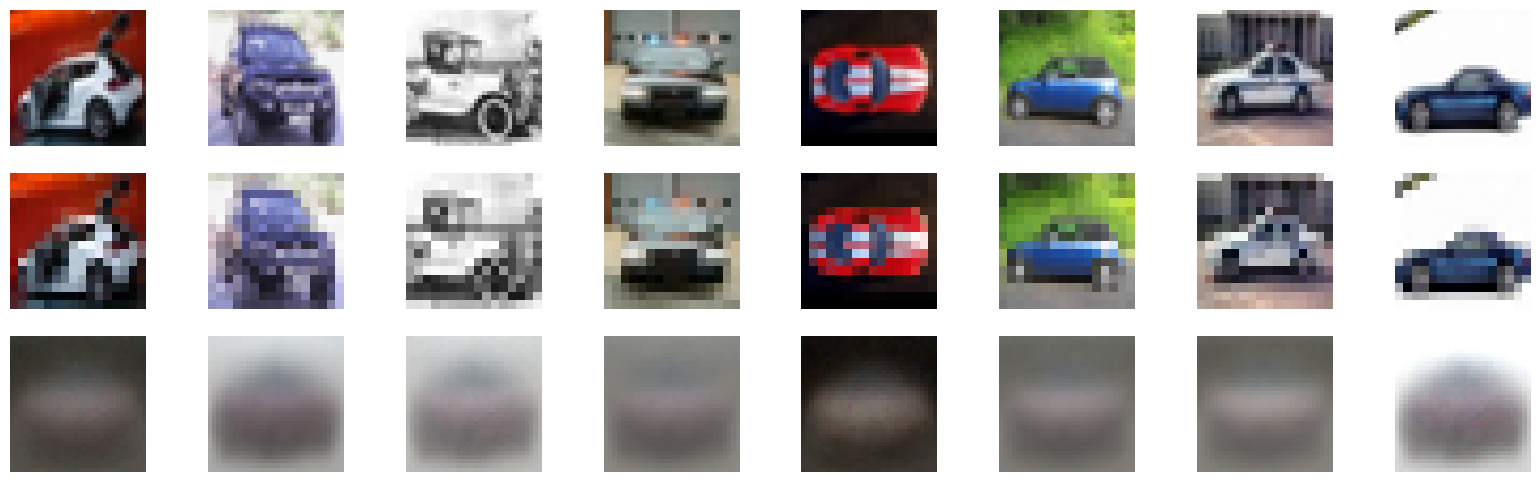

In [14]:
show_image(x, x_inp, x_hat, 8)